In [1]:
# coding:utf-8
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata
from chainer import cuda, Variable, FunctionSet,\
     optimizers,Chain,serializers
import chainer.functions  as F
import sys

import time

import datetime
import Dataload

import cv2


#np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def to_plot(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
def to_grayscale(img):
    grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return grayed
def blur(img):
    filtered = cv2.GaussianBlur(img, (11, 11), 0,0)
    return filtered
def threshold(img):
    th1 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
    return th1
def detect_contour(img, min_size):
    flip_img=255-threshold(blur(to_grayscale(img)))
    drawed_img = img
    
    #contoured = cv2.imread(path)
    #forcrop = cv2.imread(path)

    # detect contour
    im, contours, hierarchy = cv2.findContours(flip_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    #切り取った画像の集合
    crops = []
    
    # draw contour
    for cnt in contours:
        if cv2.contourArea(cnt) < min_size:
            continue

        # rectangle area
        x, y, w, h = cv2.boundingRect(cnt)
        
        #ギリギリの接戦になっているので周りに余裕を持たす。
        x, y, w, h = padding_position(x, y, w, h, 5)

        # crop the image
        cropped = img[y:(y + h), x:(x + w)]
        #cropped = cv2.resize(cropped, (140, 140))
        cropped = to_matplotlib_format(cropped)
        crops.append(cropped)

        # draw contour
        cv2.drawContours(drawed_img, [cnt], 0, (255, 0, 0), 2)  # contour
        cv2.rectangle(drawed_img, (x, y), (x + w, y + h), (0, 0,255), 5)  #rectangle contour
    return drawed_img, crops

def padding_position(x, y, w, h, p):
    return x - p, y - p, w + p * 2, h + p * 2

def detect_contour2(img):
    #flip_img=255-threshold(blur(to_grayscale(img)))
    flip_img=threshold(blur(to_grayscale(img)))
    drawed_img = img

    # detect contour
    im, contours, hierarchy = cv2.findContours(flip_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    
    #切り取った画像の集合
    crops = []
    
    AreaArray = np.zeros((len(contours)))    
    i=0                    
    for cnt in contours:
        AreaArray[i]=cv2.contourArea(cnt)
        i+=1
    
    max_cnt=contours[AreaArray.argmax()]
    AreaArray[AreaArray.argmax()]=0
    second_max_cnt=contours[AreaArray.argmax()]

    # rectangle area
    x, y, w, h = cv2.boundingRect(second_max_cnt)
        
    # crop the image
    cropped = img[y:(y + h), x:(x + w)]
    cropped = to_matplotlib_format(cropped)
    crops.append(cropped)

    # draw contour
    cv2.drawContours(drawed_img, [second_max_cnt], 0, (255, 0, 0), 2)  # contour
    cv2.rectangle(drawed_img, (x, y), (x + w, y + h), (0, 0,255), 5)  #rectangle contour
    return drawed_img, crops





In [3]:
def BunKatu(img):
    HalfLine = img.shape[1]/2
    BeforeImage = img[: , 0:HalfLine]
    AfterImage = img[: , HalfLine: ]
    return BeforeImage,AfterImage


for i in range(1,189):
    img = cv2.imread("./DataKeep/Picture/BeforeAfter/BeforeAfter%d.jpg"%(i))
    Before_img,After_img = BunKatu(img)
    cv2.imwrite('./DataKeep/Picture/Before/Before%d.jpg'%(i),Before_img)
    cv2.imwrite('./DataKeep/Picture/After/After%d.jpg'%(i),After_img)


In [6]:
def FaceCut(img):
    #Dir = "/Users/okuyamatakashi/.pyenv/versions/anaconda-4.0.0/pkgs/opencv3-3.1.0-py27_0/share/OpenCV/haarcascades/"
    Dir = "./haarcascadesWin/"
    face_cascade = cv2.CascadeClassifier(Dir+'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(Dir+'haarcascade_eye.xml')

    #grayed_img = to_grayscale(img)
    #grayed_img = img
    grayed_img = 255 - threshold(blur(to_grayscale(img)))
    drawed_img = img

    faces = face_cascade.detectMultiScale(grayed_img, 1.3, 5)
    for (x,y,w,h) in faces:
        cv2.rectangle(drawed_img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = grayed_img[y:y+h, x:x+w]
        roi_color = drawed_img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    
    return drawed_img , len(faces)

def BodyCut(img):
    Dir = "/Users/okuyamatakashi/.pyenv/versions/anaconda-4.0.0/pkgs/opencv3-3.1.0-py27_0/share/OpenCV/haarcascades/"
    body_cascade = cv2.CascadeClassifier(Dir+'haarcascade_upperbody.xml')

    grayed_img = to_grayscale(img)
    drawed_img = img

    #faces = face_cascade.detectMultiScale(grayed_img, 1.3, 5)
    bodys = body_cascade.detectMultiScale(grayed_img, 1.3, 5)
    #print len(bodys)
    for (x,y,w,h) in bodys:
        cv2.rectangle(drawed_img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = grayed_img[y:y+h, x:x+w]
        roi_color = drawed_img[y:y+h, x:x+w]
    return drawed_img

0.0
0.0


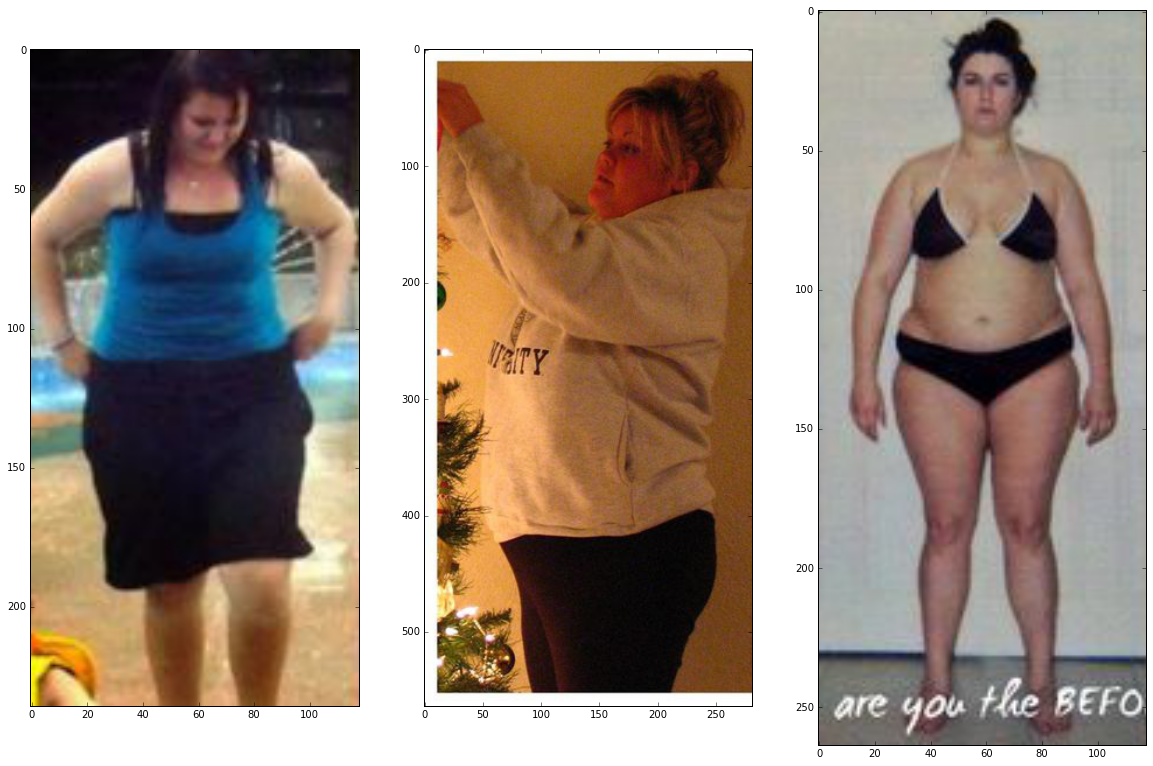

In [7]:
Data_Num = 189
Before_img = [0]*Data_Num
After_img = [0]*Data_Num

Kenshutu_Num = 0.0

for i in range(Data_Num):
    BeforeAfter = cv2.imread('./DataKeep/Picture/BeforeAfter/BeforeAfter%d.jpg'%(i+1))
    Before =cv2.imread('./DataKeep/Picture/Before/Before%d.jpg'%(i+1))
    After =cv2.imread('./DataKeep/Picture/After/After%d.jpg'%(i+1))
    Before_img[i] = Before
    After_img[i] = After
    Kenshutu_img , a = FaceCut(BeforeAfter)
    Kenshutu_Num += a
    #cv2.imwrite('./Picture/Kenshutu/Kenshutu_Before%d.jpg'%(i+1),Kenshutu_img)
Kenshutu_Acc = Kenshutu_Num/(Data_Num*2)
print Kenshutu_Num
print Kenshutu_Acc

plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(to_plot(Before_img[1]))
plt.subplot(1,3,2)
plt.imshow(to_plot(Before_img[2]))
plt.subplot(1,3,3)
plt.imshow(to_plot(Before_img[3]))


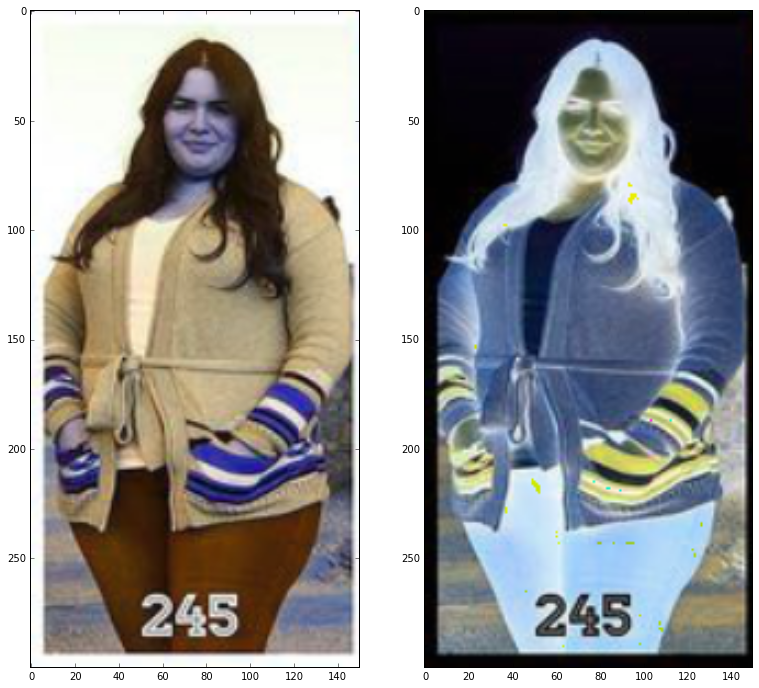

In [159]:
N=2
N_train=1

height = 300
width = 150

for i in range(N/2):
        #BeforeAfter = cv2.imread('./DataKeep/Picture/BeforeAfter/BeforeAfter%d.jpg'%(i+1))
        Before =cv2.imread\
        ('./DataKeep/Picture/Before/Before%d.jpg'%(i+1))
        After =cv2.imread\
        ('./DataKeep/Picture/After/After%d.jpg'%(i+1))

        Before=cv2.resize(Before,(width,height))
        After=cv2.resize(After,(width,height))
        
        plt.figure(figsize=(20, 20))
        plt.subplot(1,3,1)
        plt.imshow(Before)
        
        Before = Before.reshape(height*width*3)
        After = After.reshape(height*width*3)
        Before = np.hstack((Before,np.array([0])))
        After = np.hstack((After,np.array([1])))
        BeforeAfter=np.vstack((Before,After))
        if i == 0:
            dataset = BeforeAfter
        elif i >= 1:
            dataset = np.vstack((dataset,BeforeAfter))

            np.random.shuffle(dataset)
color_x = dataset[:,:height*width*3]
label = dataset[:,height*width*3:]

color_x = color_x.reshape(N,height,width,3)

plt.subplot(1,3,2)
plt.imshow(color_x[0])

In [8]:
N=2
N_train=1

height = 5
width = 5

#BeforeAfter = cv2.imread('./DataKeep/Picture/BeforeAfter/BeforeAfter%d.jpg'%(i+1))
Before =cv2.imread('./DataKeep/Picture/Before/Before%d.jpg'%(i+1))
After =cv2.imread('./DataKeep/Picture/After/After%d.jpg'%(i+1))

Before=cv2.resize(Before,(width,height))
After=cv2.resize(After,(width,height))

print Before.dtype

print "\n\n"
        
gray_Before=gray = to_grayscale(Before)
        
Before1 = Before.reshape(height*width*3)
Before2 = np.hstack((Before1,np.array([0])))

f=Before2[:height*width*3].reshape(height,width,3)
print f.dtype

f = f.astype(np.uint8)
f=to_grayscale(f)

#print f - Before

plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(Before)
plt.subplot(1,3,2)
plt.imshow(f)



error: ..\..\..\modules\imgproc\src\imgwarp.cpp:3229: error: (-215) ssize.area() > 0 in function cv::resize
